<a href="https://colab.research.google.com/github/keymc021/work/blob/master/road_detection_and_creating_grid_points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I introduce how to detect road from open street map and how to create grid points from road data. 
The generated grid points may be used for "snap to grid". Please refer [original notebook](https://www.kaggle.com/robikscube/indoor-navigation-snap-to-grid-post-processing ) to know the detail of "snap to grid".

Actually, I haven't applied these grids to "Snap to Grid" well yet by some problem, and I'm still trying to figure it out.
Plese comment if there are my mistakes or any idea.

Reference sites:  
https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa

In [ ]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import plotly.express as px

In [ ]:
data_dir = Path("../input/google-smartphone-decimeter-challenge")
train_df = pd.read_csv(data_dir / "baseline_locations_train.csv")

In [ ]:
# get all ground truth dataframe
gt_df = pd.DataFrame()
for (collection_name, phone_name), df in tqdm(train_df.groupby(["collectionName", "phoneName"])):
    path = data_dir / f"train/{collection_name}/{phone_name}/ground_truth.csv"
    df = pd.read_csv(path)  
    gt_df = pd.concat([gt_df, df]).reset_index(drop=True)   
gt_df.head()

  0%|          | 0/73 [00:00<?, ?it/s]

collectionName phoneName  millisSinceGpsEpoch     latDeg      lngDeg  \
0  2020-05-14-US-MTV-1    Pixel4        1273529463442  37.423576 -122.094132   
1  2020-05-14-US-MTV-1    Pixel4        1273529464442  37.423576 -122.094132   
2  2020-05-14-US-MTV-1    Pixel4        1273529465442  37.423576 -122.094132   
3  2020-05-14-US-MTV-1    Pixel4        1273529466442  37.423576 -122.094132   
4  2020-05-14-US-MTV-1    Pixel4        1273529467442  37.423576 -122.094132   

   heightAboveWgs84EllipsoidM  timeSinceFirstFixSeconds  hDop  vDop  speedMps  \
0                       33.21                    551.44   1.1   0.0       0.0   
1                       33.21                    552.44   1.1   0.0       0.0   
2                       33.21                    553.44   1.1   0.0       0.0   
3                       33.20                    554.44   1.1   0.0       0.0   
4                       33.20                    555.44   1.1   0.0       0.0   

   courseDegree  
0          12.7  
1          12.7  
2          12.7  
3          12.7  
4          12.7

In [ ]:
fig = px.scatter_mapbox(gt_df,

                    # Here, plotly gets, (x,y) coordinates
                    lat="latDeg",
                    lon="lngDeg",
                    text='phoneName',

                    #Here, plotly detects color of series
                    color="collectionName",
                    labels="collectionName",

                    zoom=9,
                    center={"lat":37.423576, "lon":-122.094132},
                    height=600,
                    width=800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(title_text="GPS trafic")
fig.show()

## Target place
Let's take '2021-04-29-US-SJC-2' as an example.

In [ ]:
target_collection = '2021-04-29-US-SJC-2'
target_gt_df = gt_df[gt_df["collectionName"]==target_collection].reset_index(drop=True)
target_collection

'2021-04-29-US-SJC-2'

In [ ]:
fig = px.scatter_mapbox(target_gt_df,

                    # Here, plotly gets, (x,y) coordinates
                    lat="latDeg",
                    lon="lngDeg",
                    text='phoneName',

                    #Here, plotly detects color of series
                    color="collectionName",
                    labels="collectionName",

                    zoom=15,
                    center={"lat":37.33351, "lon":-121.8906},
                    height=600,
                    width=800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(title_text="GPS trafic")
fig.show()

## Import geographical library

In [ ]:
!pip install osmnx momepy geopandas

     |████████████████████████████████| 238 kB 1.1 MB/s 
     |████████████████████████████████| 2.4 MB 4.3 MB/s 
     |████████████████████████████████| 2.0 MB 6.7 MB/s 
     |████████████████████████████████| 115 kB 8.3 MB/s 


In [ ]:
from shapely.geometry import Point
import osmnx as ox
import momepy
import geopandas as gpd

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning:

The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.



In [ ]:
# change pd.DataFrame -> gpd.GeoDataFrame
target_gt_df["geometry"] = [Point(p) for p in target_gt_df[["lngDeg", "latDeg"]].to_numpy()]
target_gt_gdf = gpd.GeoDataFrame(target_gt_df, geometry=target_gt_df["geometry"])
target_gt_gdf.head(5)

collectionName phoneName  millisSinceGpsEpoch     latDeg      lngDeg  \
0  2021-04-29-US-SJC-2    Pixel4        1303757946435  37.334479 -121.899598   
1  2021-04-29-US-SJC-2    Pixel4        1303757947435  37.334479 -121.899598   
2  2021-04-29-US-SJC-2    Pixel4        1303757948435  37.334479 -121.899598   
3  2021-04-29-US-SJC-2    Pixel4        1303757949435  37.334479 -121.899598   
4  2021-04-29-US-SJC-2    Pixel4        1303757950435  37.334479 -121.899598   

   heightAboveWgs84EllipsoidM  timeSinceFirstFixSeconds  hDop  vDop  speedMps  \
0                       56.64                    263.44   0.5   0.0       0.0   
1                       56.64                    264.44   0.5   0.0       0.0   
2                       56.64                    265.44   0.5   0.0       0.0   
3                       56.64                    266.44   0.5   0.0       0.0   
4                       56.64                    267.44   0.5   0.0       0.0   

   courseDegree                     geometry  
0          61.1  POINT (-121.89960 37.33448)  
1          61.1  POINT (-121.89960 37.33448)  
2          61.1  POINT (-121.89960 37.33448)  
3          61.1  POINT (-121.89960 37.33448)  
4          61.1  POINT (-121.89960 37.33448)

<AxesSubplot:>

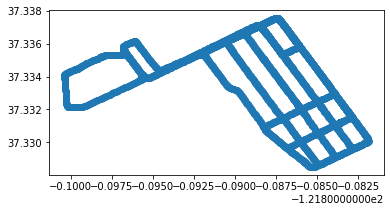

In [ ]:
target_gt_gdf.plot()

We can get road data from open street map by creating bounding box. 

In [ ]:
# get road data from open street map by osmnx
offset = 0.1**5
bbox = target_gt_gdf.bounds + [-offset, -offset, offset, offset]
east = bbox["minx"].min()
west = bbox["maxx"].max()
south = bbox["miny"].min()
north = bbox["maxy"].max()
G = ox.graph.graph_from_bbox(north, south, east, west, network_type='drive')

In [ ]:
ox.folium.plot_graph_folium(G)

In [ ]:
nodes, edges = momepy.nx_to_gdf(G)

/opt/conda/lib/python3.7/site-packages/momepy/utils.py:418: UserWarning:

Approach is not set. Defaulting to 'primal'.



In [ ]:
nodes.head()

y           x          highway  street_count  nodeID  ref  \
0  37.335294 -121.897948             stop             3       0  NaN   
1  37.335370 -121.896596             stop             3       1  NaN   
2  37.336402 -121.898691  traffic_signals             4       2  NaN   
3  37.336552 -121.898785  traffic_signals             4       3  NaN   
4  37.337067 -121.897707              NaN             3       4  NaN   

                      geometry  
0  POINT (-121.89795 37.33529)  
1  POINT (-121.89660 37.33537)  
2  POINT (-121.89869 37.33640)  
3  POINT (-121.89878 37.33655)  
4  POINT (-121.89771 37.33707)

In [ ]:
edges.head()

osmid                     name    highway  oneway   length  \
0   41932176  North Almaden Boulevard  secondary   False  120.474   
1   41932176  North Almaden Boulevard  secondary   False  120.474   
2  417910134  North Almaden Boulevard  secondary    True   62.399   
3  417891836       West Julian Street  secondary    True   18.264   
4  158245357  North Almaden Boulevard  secondary    True  139.706   

                                            geometry lanes bridge maxspeed  \
0  LINESTRING (-121.89795 37.33529, -121.89791 37...   NaN    NaN      NaN   
1  LINESTRING (-121.89660 37.33537, -121.89673 37...   NaN    NaN      NaN   
2  LINESTRING (-121.89660 37.33537, -121.89648 37...   NaN    NaN      NaN   
3                                               None     3    NaN      NaN   
4  LINESTRING (-121.89869 37.33640, -121.89864 37...     1    NaN      NaN   

   ref  node_start  node_end  
0  NaN           0         1  
1  NaN           1         0  
2  NaN           1       112  
3  NaN           2        92  
4  NaN           2         0

In this notebook, I use only edges data.

<AxesSubplot:>

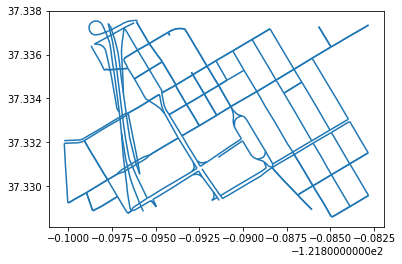

In [ ]:
edges.plot()

Since it still contains extra roads, we will leave only the relevant roads.

In [ ]:
edges = edges.dropna(subset=["geometry"]).reset_index(drop=True)
hits = bbox.apply(lambda row: list(edges.sindex.intersection(row)), axis=1)
tmp = pd.DataFrame({
    # index of points table
    "pt_idx": np.repeat(hits.index, hits.apply(len)),
    # ordinal position of line - access via iloc later
    "line_i": np.concatenate(hits.values)
})
# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(edges.reset_index(drop=True), on="line_i")
# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(target_gt_gdf.geometry.rename("point"), on="pt_idx")
# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(tmp, geometry="geometry", crs=target_gt_gdf.crs)

In [ ]:
tmp.head()

pt_idx  line_i                                              osmid name  \
0      45   179.0  [28357376, 395452213, 184867253, 946401467, 28...  NaN   
1      46   179.0  [28357376, 395452213, 184867253, 946401467, 28...  NaN   
2      47   179.0  [28357376, 395452213, 184867253, 946401467, 28...  NaN   
3      48   179.0  [28357376, 395452213, 184867253, 946401467, 28...  NaN   
4      49   179.0  [28357376, 395452213, 184867253, 946401467, 28...  NaN   

         highway  oneway   length  \
0  motorway_link    True  391.687   
1  motorway_link    True  391.687   
2  motorway_link    True  391.687   
3  motorway_link    True  391.687   
4  motorway_link    True  391.687   

                                            geometry   lanes bridge maxspeed  \
0  LINESTRING (-121.89851 37.33648, -121.89827 37...  [1, 2]    yes      NaN   
1  LINESTRING (-121.89851 37.33648, -121.89827 37...  [1, 2]    yes      NaN   
2  LINESTRING (-121.89851 37.33648, -121.89827 37...  [1, 2]    yes      NaN   
3  LINESTRING (-121.89851 37.33648, -121.89827 37...  [1, 2]    yes      NaN   
4  LINESTRING (-121.89851 37.33648, -121.89827 37...  [1, 2]    yes      NaN   

   ref  node_start  node_end                        point  
0  NaN          92        50  POINT (-121.89847 37.33505)  
1  NaN          92        50  POINT (-121.89837 37.33509)  
2  NaN          92        50  POINT (-121.89827 37.33514)  
3  NaN          92        50  POINT (-121.89819 37.33517)  
4  NaN          92        50  POINT (-121.89813 37.33520)

## Find closest road

In [ ]:
tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))

# Discard any lines that are greater than tolerance from points
tolerance = 0.0005  
tmp = tmp.loc[tmp.snap_dist <= tolerance]
# Sort on ascending snap distance, so that closest goes to top
tmp = tmp.sort_values(by=["snap_dist"])

# group by the index of the points and take the first, which is the
# closest line 
closest = tmp.groupby("pt_idx").first()
# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")
closest = closest.drop_duplicates("line_i").reset_index(drop=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None




<AxesSubplot:>

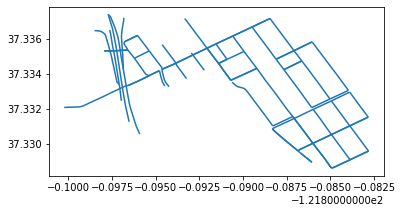

In [ ]:
closest.plot()

In [ ]:
closest.head()

line_i                                              osmid  \
0   179.0  [28357376, 395452213, 184867253, 946401467, 28...   
1     0.0                                           41932176   
2     1.0                                           41932176   
3    58.0  [28357317, 28357351, 28357352, 157782059, 2835...   
4   113.0         [394113796, 28357428, 28357429, 395444326]   

                      name        highway  oneway   length  \
0                     None  motorway_link    True  391.687   
1  North Almaden Boulevard      secondary   False  120.474   
2  North Almaden Boulevard      secondary   False  120.474   
3        Guadalupe Freeway       motorway    True  692.427   
4  North Almaden Boulevard  motorway_link    True  331.499   

                                            geometry   lanes bridge maxspeed  \
0  LINESTRING (-121.89851 37.33648, -121.89827 37...  [1, 2]    yes     None   
1  LINESTRING (-121.89795 37.33529, -121.89791 37...  [1, 2]    yes     None   
2  LINESTRING (-121.89660 37.33537, -121.89673 37...  [1, 2]    yes       65   
3  LINESTRING (-121.89653 37.33126, -121.89672 37...       3    yes       65   
4  LINESTRING (-121.89685 37.33424, -121.89689 37...  [1, 2]    yes       65   

     ref  node_start  node_end                        point  snap_dist  
0   None          92        50  POINT (-121.89810 37.33522)   0.000483  
1   None           0         1  POINT (-121.89791 37.33529)   0.000014  
2  CA 87           1         0  POINT (-121.89763 37.33529)   0.000012  
3  CA 87          28        52  POINT (-121.89723 37.33531)   0.000006  
4  CA 87          51       114  POINT (-121.89690 37.33534)   0.000009

Then, we can obtain the road data corresponding to the target data. These features may be used for modeling.
  
Next, I generate grid points from road data.

## Generate road points

In [ ]:
line_points_list = []
split = 50  # param: number of split in each LineString
for dist in range(0, split, 1):
    dist = dist/split
    line_points = closest["geometry"].interpolate(dist, normalized=True)
    line_points_list.append(line_points)
line_points = pd.concat(line_points_list).reset_index(drop=True)
line_points = line_points.reset_index().rename(columns={0:"geometry"})
line_points["lngDeg"] = line_points["geometry"].x
line_points["latDeg"] = line_points["geometry"].y

In [ ]:
fig = px.scatter_mapbox(line_points,

                    # Here, plotly gets, (x,y) coordinates
                    lat="latDeg",
                    lon="lngDeg",

                    zoom=15,
                    center={"lat":37.33351, "lon":-121.8906},
                    height=600,
                    width=800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(title_text="GPS trafic")
fig.show()

I shared the road detection and creating grid points in this notebook.

I hope it helps. Thanks!